In [1]:
%cd /home/druhe/rail1/src/cnf
%load_ext autoreload
%autoreload 2

import os
os.environ['DATAROOT'] = '/home/druhe/datasets'


/home/druhe/rail1/src/cnf


/home/druhe/rail1/src/cnf/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

In [3]:
mnist = datasets.MNIST(os.environ['DATAROOT'], train=True, download=True, transform=transforms.ToTensor())

In [4]:
example = mnist[0][0]

In [5]:
image_tensor = example[None]
batch_size = 1
n=2048
batch_size = len(image_tensor)
coordinates = torch.rand(batch_size, n, 2, device="cpu") * 2 - 1
targets = F.grid_sample(
    image_tensor, coordinates.unsqueeze(2), align_corners=True, mode="nearest"
)


In [6]:
targets.shape

torch.Size([1, 1, 2048, 1])

In [7]:
keep = coordinates[targets[:, 0, :, 0] > 0]

In [8]:
import matplotlib.pyplot as plt

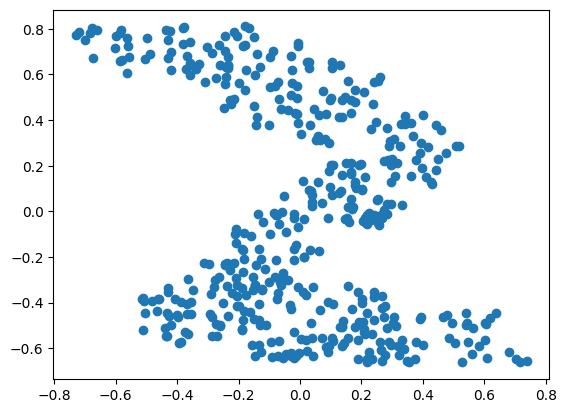

In [9]:
plt.scatter(keep[:, 0], keep[:, 1])

In [10]:
class PoolingLayer(nn.Module):

    def __init__(self, input_channels, output_channels):

        super().__init__()

        self.proj = nn.Linear(input_channels, output_channels)

    def forward(self, input):

        h = self.proj(input).transpose(1, 2) / 10
        return h @ input



pooling = PoolingLayer(2, 64)

pooled = pooling(keep[None])





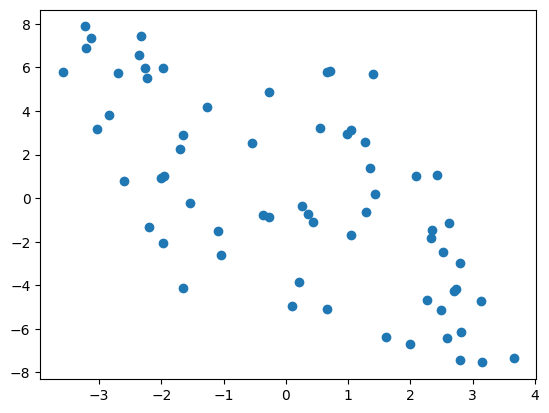

In [11]:
to_plot = pooled.detach().cpu().numpy()
plt.scatter(to_plot[0, :, 0], to_plot[0, :, 1])

In [12]:
pooled.shape, keep.shape

(torch.Size([1, 64, 2]), torch.Size([452, 2]))

In [13]:
ip = torch.einsum("bnc,bmc->bnm", pooled, keep[None])

cdist = torch.cdist(keep[None], pooled)

In [14]:
result = torch.einsum('bnm,bnc->bmc', F.softmax(cdist, dim=-1), keep[None])

In [15]:
to_plot = result.detach().cpu().numpy()

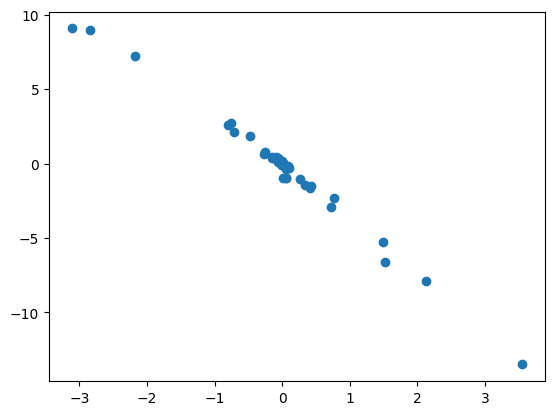

In [16]:
plt.scatter(to_plot[0, :, 0], to_plot[0, :, 1])

In [17]:
import torch
x = torch.randn(1024, 1024)

y = torch.randn(1024, 1024)

((x * y).sum(0) / 32).std()

tensor(1.0008)

In [18]:
import torch.nn.functional as F

In [19]:
x = torch.tensor([[-0.5], [0.4]])
x_ = torch.tensor([[0.4], [-0.5]])

In [20]:
x[:, None] * x[None, :]

c = torch.einsum("im, jm -> mij", x, x)
c_ = torch.einsum("im, jm -> mij", x_, x_)

In [21]:
# c = torch.stack([x * x[0], x* x[1]]).repeat(1, 1, 1).permute(2, 0, 1)  # last_dim = m
# c_ = torch.stack([x_ * x_[0], x_ * x_[1]]).repeat(1, 1, 1).permute(2, 0, 1)  # last_dim=m (1, 1, m)

In [22]:
w = F.softmax(c * 100, dim=-1)
w_ = F.softmax(c_ * 100, dim=-1)

In [23]:
w.shape

torch.Size([1, 2, 2])

In [24]:
# w = torch.stack([x == x[0], x==x[1]]).permute(2, 0, 1).float()
# w_ = torch.eye(2)[None].repeat(2, 1, 1)

res = torch.einsum('nc, mno -> cmo', x, w).sum(0)  # instead of summing can do linear
res_ = torch.einsum('nc, mno -> cmo', x_, w_).sum(0)  # instead of summing can do linear

In [25]:
res_, res

(tensor([[ 0.4000, -0.5000]]), tensor([[-0.5000,  0.4000]]))

In [26]:
res_.shape

torch.Size([1, 2])

In [27]:
x = torch.tensor([[-0.5], [0.4]])
x_ = torch.tensor([[0.4], [-0.5]])



In [87]:
# to learn this map i need two output channels, where the first one matches x1 and the second one matches x2.

x = torch.tensor([[-2., -1], [0, 3]])
x_ = torch.stack([x[1], x[0]])
x = x[:, None]
x_ = x_[:, None]

n = x.norm(dim=-1, keepdim=True)
n_ = x_.norm(dim=-1, keepdim=True)


f01 = lambda x: x[0].norm()
f02 = lambda x: -x[1].norm()

f02 = lambda x: -x[0].norm()
f12 = lambda x: x[1].norm()


c1 = f01(x) * x[0] + f11(x) * x[1]
c2 = f02(x) * x[0] + f12(x) * x[1]

c1_ = f01(x_) * x_[0] + f11(x_) * x_[1]
c2_ = f02(x_) * x_[0] + f12(x_) * x_[1]

# c1 = torch.sum(-(x.norm(dim=-1) - 2.2361)**2 , dim=0)
# c2 = torch.sum(-(x.norm(dim=-1) - 3)**2 , dim=0)

# c1_ = torch.sum(-(x_.norm(dim=-1) - 2.2361)**2 , dim=0)
# c2_ = torch.sum(-(x_.norm(dim=-1) - 3)**2 , dim=0)

c = torch.stack([c1, c2], dim=1)
c_ = torch.stack([c1_, c2_], dim=1)


c = c.repeat(1, 1, 1)
c_ = c_.repeat(1, 1, 1)

print(c)
print(c_)

tensor([[[ -4.4721, -11.2361],
         [  4.4721,  11.2361]]])
tensor([[[  4.4721,  11.2361],
         [ -4.4721, -11.2361]]])


In [70]:
z = torch.einsum('mod, ncd -> mno', c, x)
z_ = torch.einsum('mod, ncd -> mno', c_, x_)  # Where to aggregate c here it's 1 so trivial.

In [71]:
print(z.shape)

torch.Size([2, 2, 1])


In [72]:
z[0]

tensor([[-14.],
        [-42.]])

In [73]:
w = torch.softmax(z * 100, dim=1)
w_ = torch.softmax(z_ * 100, dim=1)

w, w_

(tensor([[[1.],
          [0.]],
 
         [[1.],
          [0.]]]),
 tensor([[[1.],
          [0.]],
 
         [[1.],
          [0.]]]))

In [74]:

# [2, 1, 2]
# goal: [1, 2, 2]

# x = torch.tensor([[0.5, 0.5], [-0.25, 0.7]])
# x = x[:, None]

# w = torch.eye(2)[None].repeat(2, 1, 1)  # first dim is m (new_nodes)
res = torch.einsum('ncd, mno -> mcod', x, w).sum(1)  # Can learn linear layer here.
res_ = torch.einsum('ncd, mno -> mcod', x_, w_).sum(1)  # Can learn linear layer here.

print(res.shape)

torch.Size([2, 1, 2])


In [75]:
res.transpose(0, 1) - x, res_.transpose(0, 1) - x_  # permutation not working yet.

(tensor([[[ 0.,  0.],
          [ 0.,  0.]],
 
         [[-2., -4.],
          [-2., -4.]]]),
 tensor([[[0., 0.],
          [0., 0.]],
 
         [[2., 4.],
          [2., 4.]]]))

In [57]:
x.transpose(0, 1)  # [N, C, D]

tensor([[[-2., -1.],
         [ 0.,  3.]]])

In [58]:
x.shape

torch.Size([2, 1, 2])

In [59]:
x.shape

torch.Size([2, 1, 2])

In [243]:
x.transpose(0, 1)

tensor([[[ 0.5000,  0.5000],
         [-0.2500,  0.7000]]])

In [225]:
x

tensor([[ 0.5000,  0.5000],
        [-0.2500,  0.7000]])